En este proyecto abordaremos la clasificación de incidencias de la herramienta ServiceNow, para lo cual antes de diseñar nuestro modelo necesitamos generar nuestro data set de entrenamiento, el cual no es simple, no solo es leer un data set de origen, si no que necesitaremos preparar nuestros datos. 

El flujo de trabajo general del proceso se puede dividir en varias subpartes. En la siguiente figura se muestra una descripción general de muy alto nivel.

![A diagram](https://github.com/novagenio/CognitivePV1/blob/main/images/workflow.png?raw=true)

El conjunto de datos se extrae directamente de un repositorio publico de ServiceNow. El preprocesamiento inicial de datos incluye la limpieza de datos (eliminación de duplicados, eliminación de filas vacías, eliminación de palabras vacías, etc.)
Los datos originales no estaban etiquetados y contenían solo las descripciones de los ticket. Dado que el enfoque seleccionado para este proyecto es la clasificación, necesitábamos algún mecanismo para convertir estos datos no etiquetados en datos etiquetados. 

Uno de los enfoques populares para esto es el modelado de las descripciones. El modelado de las descripciones nos permitira seleccionar las 5 categorías principales para nuestros datos, lo que nos ayudara a crear los datos etiquetados (categorías de incidentes).

Leemos los datos del fichero cvs. "No son datos extraidos de ServiceNow" son de un repositorio publico en Kaggle. 
Realizamos ELA y preprocesado

In [82]:
# libraries

### https://github.com/pankajkishore/Cognitive-Project

import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from tensorflow.keras.utils import to_categorical  # LGU
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [83]:
### Leemos los datos del dataset

### Nueva sección

Leemos los datos del dataset, mostramos, contamos categorias y definimos un target numerico por categoria

In [84]:
data = pd.read_csv('latest_ticket_data.csv')

In [85]:
data.head()

,Description,Category
0,hi since recruiter lead permission approve req...,Application
1,re expire days hi ask help update passwords co...,Application
2,verification warning hi has got attached pleas...,Application
3,please dear looks blacklisted receiving mails ...,Application
4,dear modules report report cost thank much reg...,Application


In [86]:
data.Category.value_counts()

Application         600
Database            600
Network             600
User Maintenance    600
Security            600
Name: Category, dtype: int64

In [87]:
data['target'] = data.Category.astype('category').cat.codes

In [88]:
data.head(500)

,Description,Category,target
0,hi since recruiter lead permission approve req...,Application,0
1,re expire days hi ask help update passwords co...,Application,0
2,verification warning hi has got attached pleas...,Application,0
3,please dear looks blacklisted receiving mails ...,Application,0
4,dear modules report report cost thank much reg...,Application,0
...,...,...,...
495,information user requested installation hello ...,Application,0
496,hi please issue assign thank best regards engi...,Application,0
497,unknown pipeline code hi add unknown pipeline ...,Application,0
498,setup form hello please two tickets thank kind...,Application,0


En Pandas, tenemos la libertad de agregar diferentes funciones cuando sea necesario, como función lambda, función de clasificación, etc. Podemos aplicar una función lambda tanto a las columnas como a las filas del marco de datos de Pandas.
EN este caso contaremos la palabras del campo descripción e incluiremos una etiqueta en el rango de palabras en que esta cada descripción (entre 0-100, 100-200, etc.)
Posteriormente agrupamos y revisamos la distribución del ranfo de palabras respecto a los registros de la muestra.

In [89]:
data['num_words'] = data.Description.apply(lambda x : len(x.split()))

In [90]:
bins=[0,50,75, np.inf]
data['bins']=pd.cut(data.num_words, bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-300', '300-500','500-800' ,'>800'])

In [91]:
word_distribution = data.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [92]:
word_distribution.head()

,bins,counts
0,0-100,2817
1,100-300,162
2,300-500,15
3,500-800,2
4,>800,4


Text(0.5, 1.0, 'Word distribution per bin')

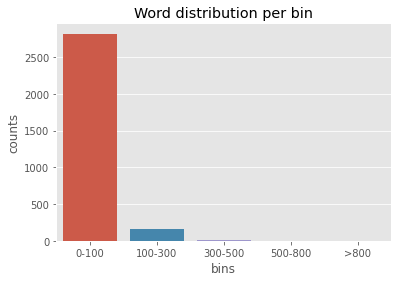

In [93]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

Aqui vemos cada registro del dataset, con su descripción, categoria, el target definido, el numero de palabras que contine caa categoria y el rango en que esta el numero de palabras.

In [94]:
data.head()

,Description,Category,target,num_words,bins
0,hi since recruiter lead permission approve req...,Application,0,12,0-100
1,re expire days hi ask help update passwords co...,Application,0,140,100-300
2,verification warning hi has got attached pleas...,Application,0,14,0-100
3,please dear looks blacklisted receiving mails ...,Application,0,14,0-100
4,dear modules report report cost thank much reg...,Application,0,8,0-100


Asignamos el target a la variable **y**, la que usaremos más adelante en el modelo. Ojo con esto.

In [95]:
num_class = len(np.unique(data.Category.values))
y = data['target'].values

# Topic Modelling

Antes de darle caña al proceso, estas son algunas de las suposiciones que consideramos:
Elegimos la cantidad de descripciones con anticipación, incluso si no estamos seguros de cuáles son.
Cada documento se representa como una distribución por descripción.
Cada descripción se representa como una distribución sobre palabras.
Usamos** Wordnet de NLTK** para encontrar los significados de palabras, sinónimos, antónimos y más. Además, usamos **WordNetLemmatizer** para obtener la raíz de la palabra.
Luego leemos nuestro conjunto de datos línea por línea y preparamos cada línea para LDA y las almacenamos en una lista.

In [96]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
import pandas as pd
import re
import warnings

#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
#from mpl_toolkits.basemap import Basemap
from wordcloud import WordCloud, STOPWORDS

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

In [97]:
data['Description'] = data['Description'].astype(str)

In [127]:
data.head(1000)

,Description,Category,target,num_words,bins
0,hi since recruiter lead permission approve req...,Application,0,12,0-100
1,re expire days hi ask help update passwords co...,Application,0,140,100-300
2,verification warning hi has got attached pleas...,Application,0,14,0-100
3,please dear looks blacklisted receiving mails ...,Application,0,14,0-100
4,dear modules report report cost thank much reg...,Application,0,8,0-100
...,...,...,...,...,...
995,client hi about working client clients establi...,Network,2,38,0-100
996,hello please having thank application engineer...,Network,2,7,0-100
997,permissions hello please kind assist possible ...,Network,2,20,0-100
998,device recovery report printer tray has proble...,Network,2,42,0-100


Proceso de tockenización de las descripciones que estan en data.Description.values y quedaran en post_seq_padded

In [103]:
MAX_LENGTH = 500
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.Description.values)
#print(data.Description.values[0])
post_seq = tokenizer.texts_to_sequences(data.Description.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)



In [105]:
X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.05,random_state=42)

In [106]:
vocab_size = len(tokenizer.word_index) + 1

# Deep Learning Model Simple

Selección y entrenamiento de modelos:
RNN para clasificación: -
Una canalización de clasificación de texto de un extremo a otro se compone de los siguientes componentes:
1. Texto de entrenamiento: Es el texto de entrada a través del cual nuestro modelo de aprendizaje supervisado es capaz de aprender y predecir la clase requerida.
2. Vector de características: un vector de características es un vector que contiene información que describe las características de los datos de entrada.
3. Etiquetas: Estas son las categorías/clases predefinidas que nuestro modelo predecirá
4. ML Algo: Es el algoritmo a través del cual nuestro modelo es capaz de lidiar con la clasificación de texto (En nuestro caso: CNN, RNN, HAN)
5. Modelo predictivo: un modelo que se entrena en el conjunto de datos históricos que puede realizar predicciones de etiquetas.

In [104]:
'''
MAX_LENGTH = 500
tokenizer = Tokenizer()

paso = pd.DataFrame()
paso['Description'] = ['hello since recruiter lead permission approve requisitions makes please make thanks recruiter']
paso.head()
paso['Description'] = paso['Description'].astype(str)


tokenizer.fit_on_texts(data.Description.values)
print(data.Description.values[0])
post_seq = tokenizer.texts_to_sequences(paso.Description.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)
print(post_seq_padded[0])

'''



"\nMAX_LENGTH = 500\ntokenizer = Tokenizer()\n\npaso = pd.DataFrame()\npaso['Description'] = ['hello since recruiter lead permission approve requisitions makes please make thanks recruiter']\npaso.head()\npaso['Description'] = paso['Description'].astype(str)\n\n\ntokenizer.fit_on_texts(data.Description.values)\nprint(data.Description.values[0])\npost_seq = tokenizer.texts_to_sequences(paso.Description.values)\npost_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)\nprint(post_seq_padded[0])\n\n"

In [ ]:
# MODELO 1
inputs = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)
x = Flatten()(embedding_layer)
x = Dense(32, activation='relu')(x)

predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)


In [ ]:
# Compile el modelo de Keras para configurar el proceso de entrenamiento:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()

In [ ]:
# Entrena el modelo
filepath="weights-simple.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=10, callbacks=[checkpointer])

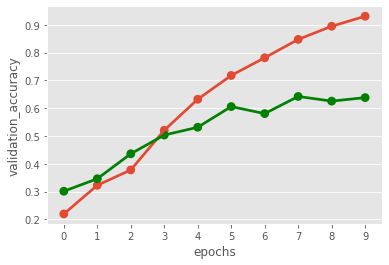

In [108]:
df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')

In [126]:

predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)
print(predicted[0])



0


In [132]:

MAX_LENGTH = 500
tokenizer = Tokenizer()

paso = pd.DataFrame()
paso['Description'] = ['complete colombia dear please help completed form testing internship student intern joining well please complete going his where he going seated thank compliance officer colombia		']
paso.head()
paso['Description'] = paso['Description'].astype(str)


tokenizer.fit_on_texts(data.Description.values)
print(data.Description.values[0])
post_seq = tokenizer.texts_to_sequences(paso.Description.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)
print(post_seq_padded[0])

predicted = model.predict(post_seq_padded)
print(predicted)




hi since recruiter lead permission approve requisitions makes please make thanks recruiter
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0  

# RNN

Clasificación de incidentes utilizando la red neuronal recurrente (RNN):
Una red neuronal recurrente (RNN) es una clase de red neuronal artificial donde las conexiones entre nodos forman un gráfico dirigido a lo largo de una secuencia. Esto le permite exhibir un comportamiento temporal dinámico durante una secuencia de tiempo.
Usar el conocimiento de una incrustación externa puede mejorar la precisión de su RNN porque integra nueva información (léxica y semántica) sobre las palabras, una información que ha sido entrenada y destilada en un corpus de datos muy grande. utilizado es GloVe.
RNN es una secuencia de bloques de redes neuronales que están vinculados entre sí como una cadena. Cada uno está pasando un mensaje a un sucesor.

In [110]:
inputs = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)

x = LSTM(64)(embedding_layer)
x = Dense(32, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)
model_lstm = Model(inputs=[inputs], outputs=predictions)
model_lstm.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model_lstm.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 500, 128)          653312    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 5)                 165       
                                                                 
Total params: 704,965
Trainable params: 704,965
Non-trainable params: 0
_________________________________________________________________


In [111]:
filepath="weights.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model_lstm.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=20, callbacks=[checkpointer])

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5548 - acc: 0.3407
Epoch 1: val_acc improved from -inf to 0.42637, saving model to weights.hdf5
34/34 [==============================] - 18s 482ms/step - loss: 1.5548 - acc: 0.3407 - val_loss: 1.4125 - val_acc: 0.4264
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1418 - acc: 0.5555
Epoch 2: val_acc improved from 0.42637 to 0.60309, saving model to weights.hdf5
34/34 [==============================] - 17s 493ms/step - loss: 1.1418 - acc: 0.5555 - val_loss: 0.9981 - val_acc: 0.6031
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.7959 - acc: 0.7113
Epoch 3: val_acc improved from 0.60309 to 0.61431, saving model to weights.hdf5
34/34 [==============================] - 16s 468ms/step - loss: 0.7959 - acc: 0.7113 - val_loss: 0.9011 - val_acc: 0.6143
Epoch 4/20
34/34 [==============================] - ETA: 0s - loss: 0.5510 - acc: 0.8114
Epoch 4: val_acc improved from 0.61431 to

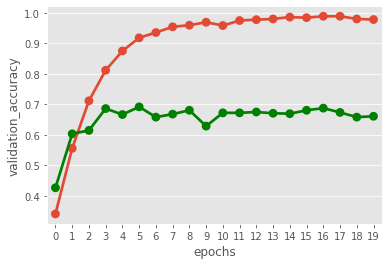

In [112]:
df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')

In [113]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.6133333333333333

In [114]:
predicted

array([0, 0, 4, 4, 3, 2, 4, 3, 2, 2, 3, 0, 1, 0, 2, 2, 2, 2, 2, 1, 0, 0,
       0, 3, 1, 2, 2, 4, 0, 4, 2, 0, 1, 2, 4, 2, 3, 0, 0, 4, 4, 4, 0, 1,
       4, 4, 3, 0, 0, 4, 2, 2, 0, 2, 2, 1, 4, 1, 2, 1, 1, 0, 1, 0, 0, 0,
       4, 0, 4, 0, 4, 2, 2, 2, 2, 2, 2, 2, 3, 2, 0, 2, 1, 4, 3, 0, 2, 4,
       2, 2, 0, 0, 2, 0, 4, 0, 2, 3, 0, 4, 3, 2, 1, 4, 4, 0, 2, 2, 0, 4,
       3, 0, 2, 3, 4, 2, 0, 0, 4, 3, 2, 2, 2, 4, 3, 3, 3, 2, 1, 2, 2, 4,
       4, 4, 2, 0, 2, 4, 2, 3, 2, 4, 2, 2, 3, 0, 3, 3, 3, 0])

In [115]:
predicted = np.argmax(predicted, axis=1)

AxisError: ignored

In [ ]:
accuracy_score(y_test, predicted)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))

In [ ]:
print(y_test, predicted)

In [ ]:
print(X_test[30])

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import itertools

In [ ]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(data.Category.values)
text_labels = encoder.classes_ 
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts("hi since recruiter lead permission approve requisitions makes please make thanks recruiter		")
post_seq = tokenizer.texts_to_sequences("hi since recruiter lead permission approve requisitions makes please make thanks recruiter	")
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

print(post_seq_padded[0])

predicted = model_lstm.predict(post_seq_padded)
print(predicted[0])